In [1]:
import gzip
import pickle

import pandas as pd
import numpy as np
import scipy

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

import anndata as ad
import scanpy as sc
import episcanpy as epi

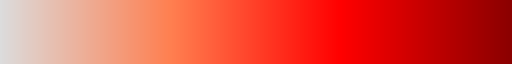

In [2]:
colors = ["gainsboro", "coral", "red", "darkred"]
cmap = LinearSegmentedColormap.from_list("my_cmap", colors)
cmap

In [3]:
def tss_enrichment_score_plot(adata, threshold=None, figsize=(4, 6), save=None):
    """
    Plots a violin plot of the individual TSS enrichment scores

    Args:
        adata: AnnData
        figsize: size of the figure
        save: if True or str, save the figure. str is appended to the default filename. infer filetype if ending on {'.pdf', '.png', '.svg'}

    Returns:
        None
    """

    import seaborn as sns
    import matplotlib.pyplot as plt

    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)

    sns.violinplot(y=adata.obs.tss_enrichment_score, inner=None, cut=0, ax=ax)
    
    if not threshold:
        sns.stripplot(y=adata.obs.tss_enrichment_score, size=1, jitter=0.3, color="black", ax=ax)
    else:
        sns.stripplot(y=adata[adata.obs.tss_enrichment_score >= threshold, :].obs.tss_enrichment_score, size=1, jitter=0.4, color="black", ax=ax)
        sns.stripplot(y=adata[adata.obs.tss_enrichment_score < threshold, :].obs.tss_enrichment_score, size=1, jitter=0.4, color="red", ax=ax)
        ax.axhline(y=threshold, color="red", linestyle="--", linewidth=1, alpha=1)
    
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.grid(False)
    ax.set_ylabel("TSS enrichment score")
    ax.set_title("TSS enrichment", loc="center")

    sns.despine()

    if not save:
        plt.show()

    else:
        default_filename = "tss_enrichment_score"

        if isinstance(save, str):

            if save[-4:] in {".pdf", ".png", ".svg"}:
                filename = default_filename + save

            else:
                filename = default_filename + save + ".png"

        else:
            filename = default_filename + ".png"

        plt.savefig(filename)

In [4]:
def pl_pc_nfeat_corr(adata, pcs=1, key="n_counts", max_cols=5, save=False):
    nrows = int(np.ceil(pcs / max_cols))
    ncols = int(pcs if pcs <= max_cols else max_cols)
    
    fig, axs = plt.subplots(figsize=(ncols * 5, nrows * 5), nrows=nrows, ncols=ncols, squeeze=False, sharey=True)
    axs = axs.flatten()
    
    for ax in axs[pcs:]:
        ax.remove()

    fig.subplots_adjust(hspace=0.3, wspace=0.5)

    for i in range(pcs):
        ax = axs[i]        

        ax.scatter(x=adata.obsm["X_pca"][:, i],
                   y=adata.obs[key],
                   s=12 - np.log10(adata.X.shape[0]),
                   alpha=0.7)

        ax.set_xticks([])
        ax.set_xlabel("PC{}".format(i + 1))
        if (i + 1) % max_cols == 1:
            ax.set_ylabel(key)
        
        ax.grid(b=False, axis="both")
        ax.set_axisbelow(True)
    
    plt.tight_layout()
    
    if save:
        plt.savefig(save, dpi=300)
    else:
        plt.show()

In [5]:
name = "GSM3722064"

base_dir = "/home/ph/data/temporary/for_katia_akshaya/"

fig_dir = base_dir + "{}/".format(name)
sc.settings.figdir = fig_dir

peak_matrix = base_dir + "{}_peaks.h5ad".format(name)
peak_file = base_dir + "{}_peaks.narrowPeak".format(name)
fragments_file = base_dir + "GSM3722064_SU008_Tumor_Pre_fragments_sorted.tsv.gz"

gtf_file = "/home/ph/data/gtfs/gencode.v39lift37.basic.annotation.gtf.gz"
gtf_file_uncompr = "/home/ph/data/gtfs/gencode.v39lift37.basic.annotation.gtf"

In [6]:
# list_of_barcodes = pd.read_csv("{}SU008_Pre_Final_min5_cluster_order.csv".format(base_dir))
list_of_barcodes = pd.read_csv("{}SU008_Pre_final_cluster_order.csv".format(base_dir))

list_of_barcodes["bc"] = [bc.replace("cell-", "") for bc in list_of_barcodes.x]
list_of_barcodes

,x,bc
0,cell-AAAGATGTCTTCGTTA-1,AAAGATGTCTTCGTTA-1
1,cell-CCAATGATCGGTCTAA-1,CCAATGATCGGTCTAA-1
2,cell-CCCGTTAAGTTCAACC-1,CCCGTTAAGTTCAACC-1
3,cell-GTGCACGTCTTTGCAT-1,GTGCACGTCTTTGCAT-1
4,cell-TTCGCGTTCGCCTTAC-1,TTCGCGTTCGCCTTAC-1
...,...,...
499,cell-GCCATAACACCTGTGG-1,GCCATAACACCTGTGG-1
500,cell-GACCCAGAGGATGCCA-1,GACCCAGAGGATGCCA-1
501,cell-GAAGTCTTCGGGAAAC-1,GAAGTCTTCGGGAAAC-1
502,cell-AGTTTGGGTGGCCTCA-1,AGTTTGGGTGGCCTCA-1


<br><br><br><hr><br><br><br>

In [7]:
adata_atac = ad.read_h5ad(peak_matrix)

adata_atac

AnnData object with n_obs × n_vars = 230635 × 122129

In [8]:
epi.tl.find_genes(adata_atac,
                  gtf_file=gtf_file_uncompr,
                  key_added="transcript_annotation",
                  upstream=5000,
                  feature_type="transcript",
                  annotation="HAVANA",
                  raw=True)

epi.tl.find_genes(adata_atac,
                  gtf_file=gtf_file_uncompr,
                  key_added="gene_annotation",
                  upstream=5000,
                  feature_type="gene",
                  annotation="HAVANA",
                  raw=True)

<br><br><br><hr><br><br><br>

In [9]:
adata_atac.var[adata_atac.var.gene_annotation.str.fullmatch("(.*;)?{}(;.*)?".format("DPH3"))]

,transcript_annotation,gene_annotation
chr3_16306143_16306643,OXNAD1;DPH3,OXNAD1;DPH3


In [10]:
markers_basal = ["KRT14", "KRT5", "LAMB3", "KRT15", "LAMC2", "BMP7", "MYLK", "TP63", "KRT6B"]
markers_fibroblasts = ["COL1A2", "VIM", "COL6A2", "VTN", "PDGFRB", "LUM", "POSTN", "COL1A1", "CELA1"]
markers_endothelial = ["CD34", "ICAM1", "LYVE1", "TEK", "CDH5", "PECAM1", "EGFL7", "ID3", "FLT1", "GNG11", "MCAM"]
markers_others = ["TP53", "MDM2", "VEGFA", "FGF2", "PDGFB"]

In [11]:
for ga_gene_names in [markers_basal, markers_fibroblasts, markers_endothelial, markers_others]:
    for gene_name in ga_gene_names:
        adata_atac.obs[gene_name] = np.ravel(adata_atac.X[:, adata_atac.var.gene_annotation.str.fullmatch("(.*;)?{}(;.*)?".format(gene_name))].sum(axis=1))

<br><br><br><hr><br><br><br>

In [12]:
adata_atac = adata_atac[adata_atac.obs.index.isin(list_of_barcodes.bc.values)].copy()
adata_atac

AnnData object with n_obs × n_vars = 504 × 122129
    obs: 'KRT14', 'KRT5', 'LAMB3', 'KRT15', 'LAMC2', 'BMP7', 'MYLK', 'TP63', 'KRT6B', 'COL1A2', 'VIM', 'COL6A2', 'VTN', 'PDGFRB', 'LUM', 'POSTN', 'COL1A1', 'CELA1', 'CD34', 'ICAM1', 'LYVE1', 'TEK', 'CDH5', 'PECAM1', 'EGFL7', 'ID3', 'FLT1', 'GNG11', 'MCAM', 'TP53', 'MDM2', 'VEGFA', 'FGF2', 'PDGFB'
    var: 'transcript_annotation', 'gene_annotation'

In [13]:
print(np.max(adata_atac.X))

if np.max(adata_atac.X) > 1:
    epi.pp.binarize(adata_atac)
    
print(np.max(adata_atac.X))

810.0
1.0


In [14]:
adata_atac.var["n_cells"] = np.ravel(adata_atac.X.sum(axis=0))
adata_atac.var["log_n_cells"] = np.log10(adata_atac.var.n_cells)

adata_atac.obs["n_features"] = np.ravel(adata_atac.X.sum(axis=1))
adata_atac.obs["log_n_features"] = np.log10(adata_atac.obs.n_features)

In [15]:
print(adata_atac.n_obs, adata_atac.n_vars)
adata_atac = adata_atac[adata_atac.obs.n_features > 0, :].copy()
adata_atac = adata_atac[:, adata_atac.var.n_cells > 0].copy()
print(adata_atac.n_obs, adata_atac.n_vars)

504 122129
504 122129


In [16]:
adata_atac.var["n_cells"] = np.ravel(adata_atac.X.sum(axis=0))
adata_atac.var["log_n_cells"] = np.log10(adata_atac.var.n_cells)

adata_atac.obs["n_features"] = np.ravel(adata_atac.X.sum(axis=1))
adata_atac.obs["log_n_features"] = np.log10(adata_atac.obs.n_features)

In [17]:
# epi.pp.tss_enrichment(adata_atac, gtf=gtf_file, fragments=fragments_file, 
#                       method="standard", score="avg_score_of_center_region", distance_to_tss=1000, bp_per_flank=100,
#                       n_jobs=2)

# epi.pl.tss_enrichment(adata_atac, save="_profile.png")
# tss_enrichment_score_plot(adata_atac)

In [18]:
# min_tss_score = 2

# adata_atac.obs["tss_high"] = ["high" if score > min_tss_score else "low" for score in adata_atac.obs.tss_enrichment_score]
# epi.pl.tss_enrichment(adata_atac, group_by="tss_high", show_n=True, max_cols=2, figsize=None, save="_profile_stratified.png")
# tss_enrichment_score_plot(adata_atac, threshold=min_tss_score, figsize=(8, 12), save="_stratified.png")

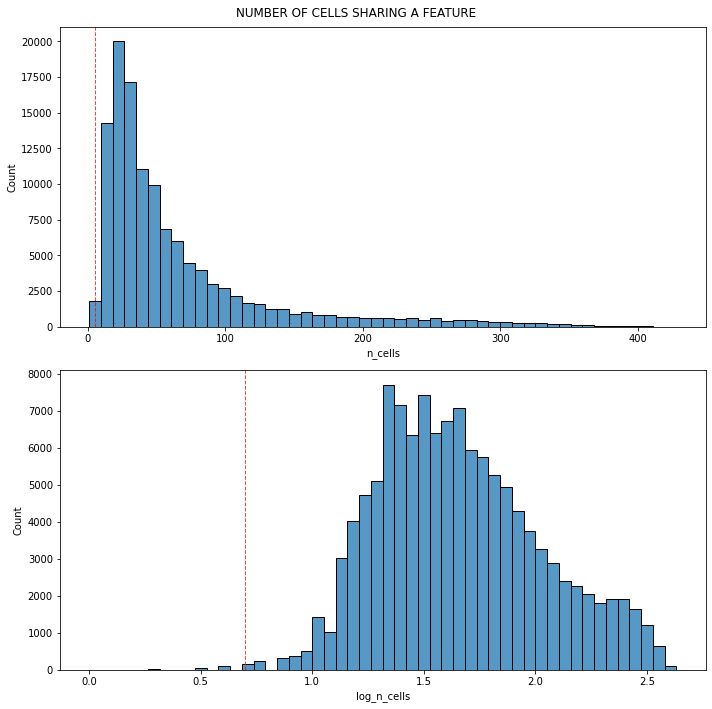

In [19]:
min_cells = 5

nrows = 2
ncols = 1

fig, axs = plt.subplots(figsize=(ncols * 10, nrows * 5), nrows=nrows, ncols=ncols, squeeze=False, sharey=False)
axs = axs.flatten()

fig.suptitle("NUMBER OF CELLS SHARING A FEATURE")

sns.histplot(adata_atac.var.n_cells, bins=50, ax=axs[0])
axs[0].axvline(x=min_cells, color="red", linestyle="--", linewidth=1, alpha=0.75)

sns.histplot(adata_atac.var.log_n_cells, bins=50, ax=axs[1])
axs[1].axvline(x=np.log10(min_cells), color="red", linestyle="--", linewidth=1, alpha=0.75)

plt.tight_layout()
plt.savefig(fig_dir + "atac_qc_hist_n_cells.png", dpi=300)

In [20]:
print(adata_atac.n_vars)
adata_atac = adata_atac[:, ~(adata_atac.var.n_cells < min_cells)].copy()
print(adata_atac.n_vars)

122129
121951


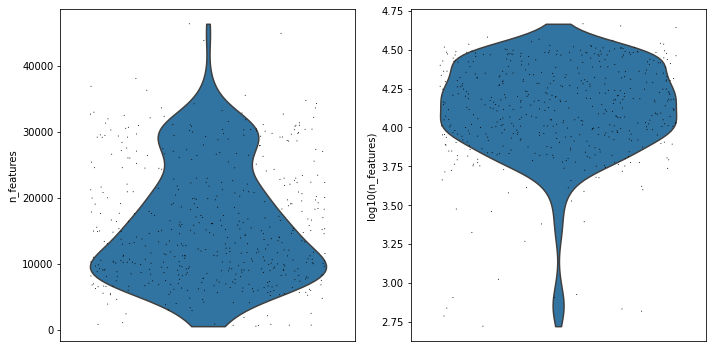

In [21]:
nrows = 1
ncols = 2

fig, axs = plt.subplots(figsize=(ncols * 5, nrows * 5), nrows=nrows, ncols=ncols, squeeze=False, sharey=False)
axs = axs.flatten()

sns.violinplot(y=adata_atac.obs.n_features, inner=None, cut=0, ax=axs[0])
sns.stripplot(y=adata_atac.obs.n_features, size=1, jitter=0.4, color="black", ax=axs[0])
axs[0].set_xticks([])
axs[0].set_ylabel("n_features")

sns.violinplot(y=adata_atac.obs.log_n_features, inner=None, cut=0, ax=axs[1])
sns.stripplot(y=adata_atac.obs.log_n_features, size=1, jitter=0.4, color="black", ax=axs[1])
axs[1].set_xticks([])
axs[1].set_ylabel("log10(n_features)")

plt.tight_layout()
plt.savefig(fig_dir + "atac_qc_violin_after_filtering.png", dpi=300) 

<br><br><br><hr><h2>FEATURE SELECTION</h2>

In [22]:
adata_atac.var["prop_shared_cells"] = adata_atac.var.n_cells / adata_atac.n_obs
adata_atac.var["variability_score"] = 1 - np.abs(adata_atac.var.prop_shared_cells - 0.5)

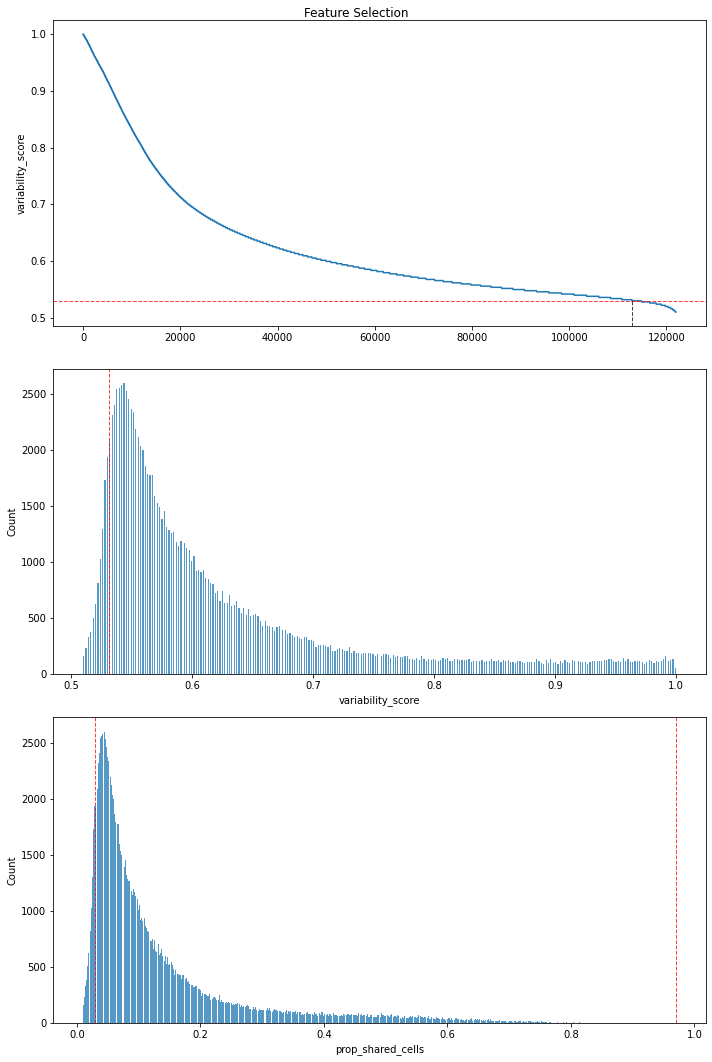

In [23]:
n_bins = 500
min_score = 0.53
n_features_selected = None

if min_score is None:
    tmp = adata_atac.var.nlargest(n_features_selected, columns="variability_score")
else:
    tmp = adata_atac.var[adata_atac.var.variability_score >= min_score]
    n_features_selected = tmp.shape[0]

min_var_score = tmp.variability_score.min()
max_var_score = tmp.variability_score.max()

min_prop_shared = tmp.prop_shared_cells.min()
max_prop_shared = tmp.prop_shared_cells.max()

nrows = 3
ncols = 1

fig, axs = plt.subplots(figsize=(ncols * 10, nrows * 5), nrows=nrows, ncols=ncols, squeeze=False, sharey=False)
axs = axs.flatten()

fig.suptitle("Feature Selection")

sns.lineplot(x=np.arange(1, adata_atac.n_vars + 1), y=adata_atac.var.variability_score.sort_values(ascending=False), ax=axs[0])
if min_score is None:
    axs[0].axvline(x=n_features_selected, color="red", linestyle="--", linewidth=1, alpha=0.75)
    lims = axs[0].get_xlim()
    axs[0].hlines(y=min_var_score, xmin=lims[0], xmax=n_features_selected, color="black", linestyle="--", linewidth=1, alpha=0.75)
    axs[0].set_xlim(lims)
else:
    axs[0].axhline(y=min_score, color="red", linestyle="--", linewidth=1, alpha=0.75)
    lims = axs[0].get_ylim()
    axs[0].vlines(x=n_features_selected, ymin=lims[0], ymax=min_var_score, color="black", linestyle="--", linewidth=1, alpha=0.75)
    axs[0].set_ylim(lims)

sns.histplot(adata_atac.var.variability_score, bins=n_bins, linewidth=0, ax=axs[1])
if min_score is None:
    axs[1].axvline(x=min_var_score, color="black", linestyle="--", linewidth=1, alpha=0.75)
else:
    axs[1].axvline(x=min_var_score, color="red", linestyle="--", linewidth=1, alpha=0.75)

sns.histplot(adata_atac.var.prop_shared_cells, bins=n_bins, linewidth=0, ax=axs[2])
if min_score is None:
    axs[2].axvline(x=min_prop_shared, color="black", linestyle="--", linewidth=1, alpha=0.75)
    axs[2].axvline(x=max_prop_shared, color="black", linestyle="--", linewidth=1, alpha=0.75)
else:
    axs[2].axvline(x=min_score - 0.5, color="red", linestyle="--", linewidth=1, alpha=0.75)
    axs[2].axvline(x=1 - (min_score - 0.5), color="red", linestyle="--", linewidth=1, alpha=0.75)

plt.tight_layout()
plt.savefig(fig_dir + "atac_feature_selection_most_var_{}.png".format(n_features_selected), dpi=300)

In [24]:
adata_atac = adata_atac[:, adata_atac.var.variability_score >= min_var_score].copy()
print(adata_atac)

AnnData object with n_obs × n_vars = 504 × 112897
    obs: 'KRT14', 'KRT5', 'LAMB3', 'KRT15', 'LAMC2', 'BMP7', 'MYLK', 'TP63', 'KRT6B', 'COL1A2', 'VIM', 'COL6A2', 'VTN', 'PDGFRB', 'LUM', 'POSTN', 'COL1A1', 'CELA1', 'CD34', 'ICAM1', 'LYVE1', 'TEK', 'CDH5', 'PECAM1', 'EGFL7', 'ID3', 'FLT1', 'GNG11', 'MCAM', 'TP53', 'MDM2', 'VEGFA', 'FGF2', 'PDGFB', 'n_features', 'log_n_features'
    var: 'transcript_annotation', 'gene_annotation', 'n_cells', 'log_n_cells', 'prop_shared_cells', 'variability_score'


<br><br><br><hr><h2>NORMALIZATION ETC</h2>

In [25]:
print("n features mean:\t{}".format(np.mean(np.ravel(adata_atac.X.sum(axis=1)))))
print("n features median:\t{}".format(np.median(np.ravel(adata_atac.X.sum(axis=1)))))

n features mean:	15729.640625
n features median:	13916.5


In [26]:
sc.pp.normalize_total(adata_atac)

In [27]:
epi.pp.log1p(adata_atac)

<br><br><br><hr><h2>EMBEDDING</h2>

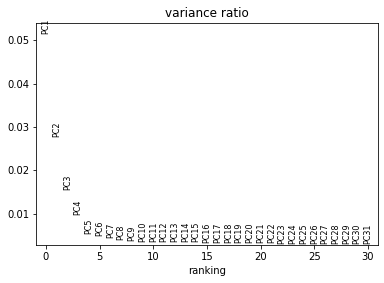

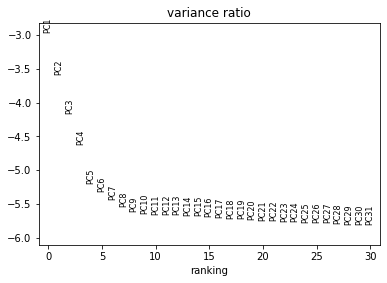

In [28]:
epi.pp.pca(adata_atac, n_comps=50, svd_solver="arpack")
epi.pl.pca_variance_ratio(adata_atac, save=".png")
epi.pl.pca_variance_ratio(adata_atac, log=True)

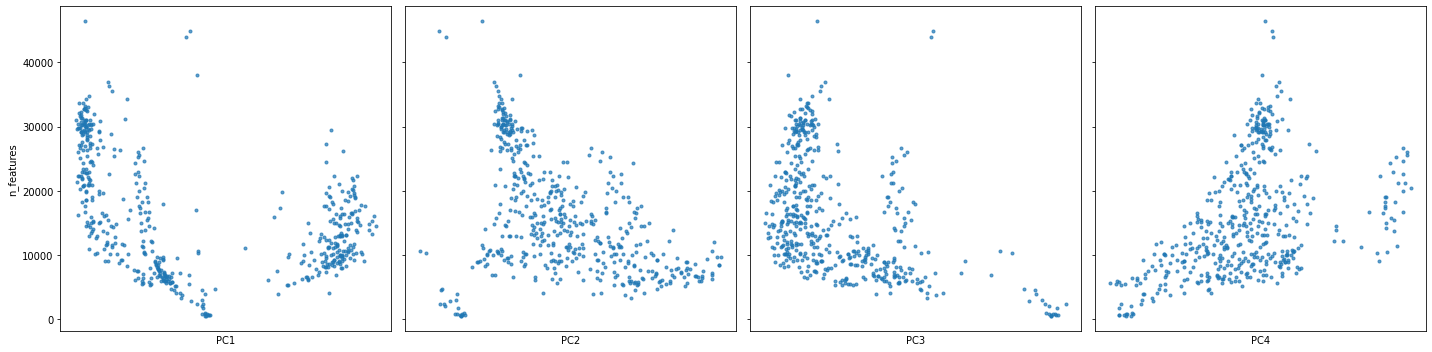

In [29]:
pl_pc_nfeat_corr(adata_atac, pcs=4, key="n_features", save="{}atac_pc_nfeat_corr_most_var_{}.png".format(fig_dir, n_features_selected))

In [30]:
epi.pp.pca(adata_atac, n_comps=4, svd_solver="arpack")

In [31]:
# print(adata_atac.obsm["X_pca"].shape)
# adata_atac.obsm["X_pca"] = np.delete(adata_atac.obsm["X_pca"], 0, 1)
# print(adata_atac.obsm["X_pca"].shape)

In [32]:
epi.pp.neighbors(adata_atac, n_neighbors=15, metric="euclidean", method="umap")
epi.tl.umap(adata_atac)

2022-03-17 11:03:01.686975: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


... storing 'transcript_annotation' as categorical
... storing 'gene_annotation' as categorical


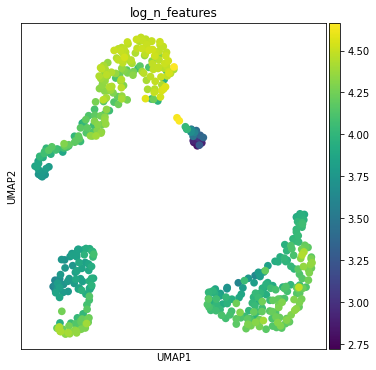

In [33]:
plt.rcParams["figure.figsize"]= (6, 6)
sc.pl.umap(adata_atac, color=["log_n_features"], ncols=2, save="_atac_emb_most_var_{}.png".format(n_features_selected))

<br><br><br><hr><br><br><br>

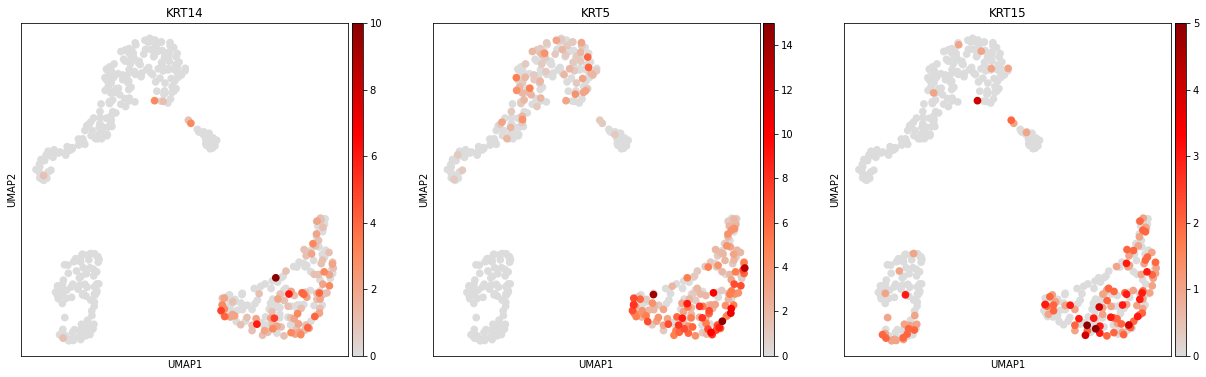

In [34]:
sc.pl.umap(adata_atac, color=['KRT14', 'KRT5', 'KRT15'], ncols=5, color_map=cmap, save="markers_basal_final.png")

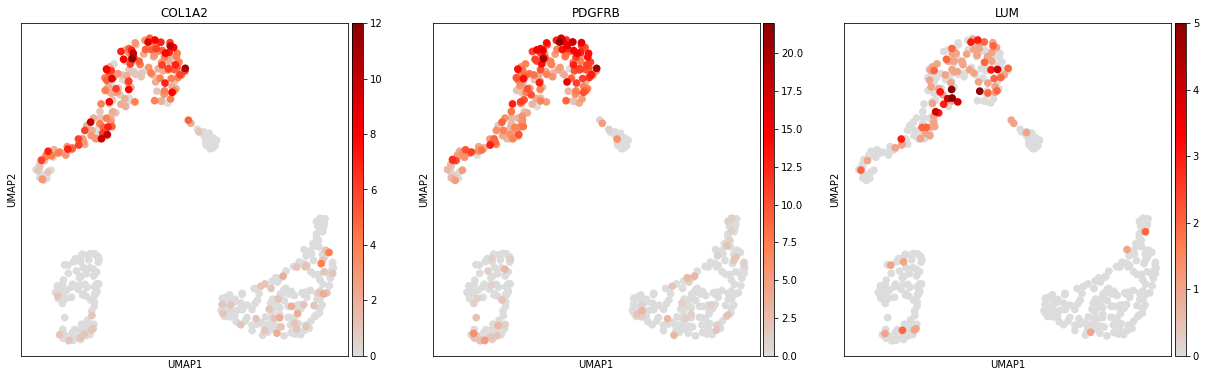

In [35]:
sc.pl.umap(adata_atac, color=['COL1A2', 'PDGFRB', 'LUM'], ncols=5, color_map=cmap, save="markers_fibroblasts_final.png")

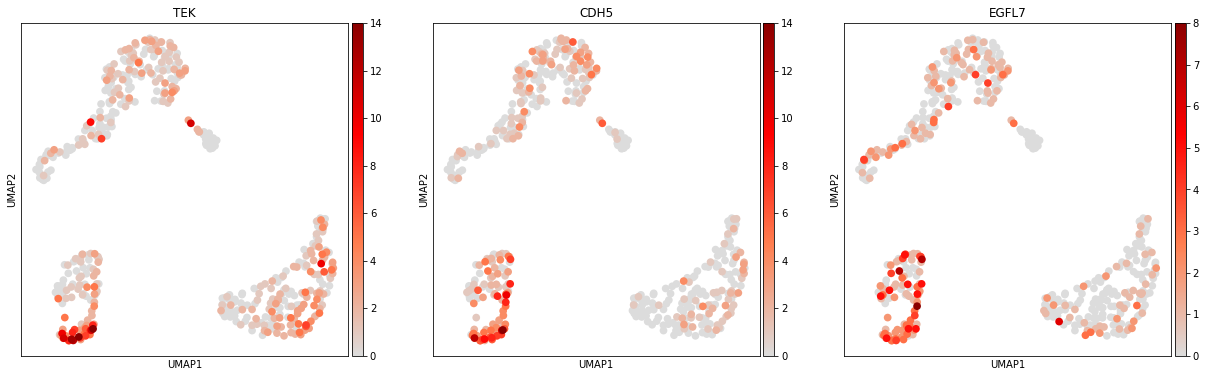

In [36]:
sc.pl.umap(adata_atac, color=['TEK', 'CDH5', 'EGFL7'], ncols=5, color_map=cmap, save="markers_endothelial_final.png")

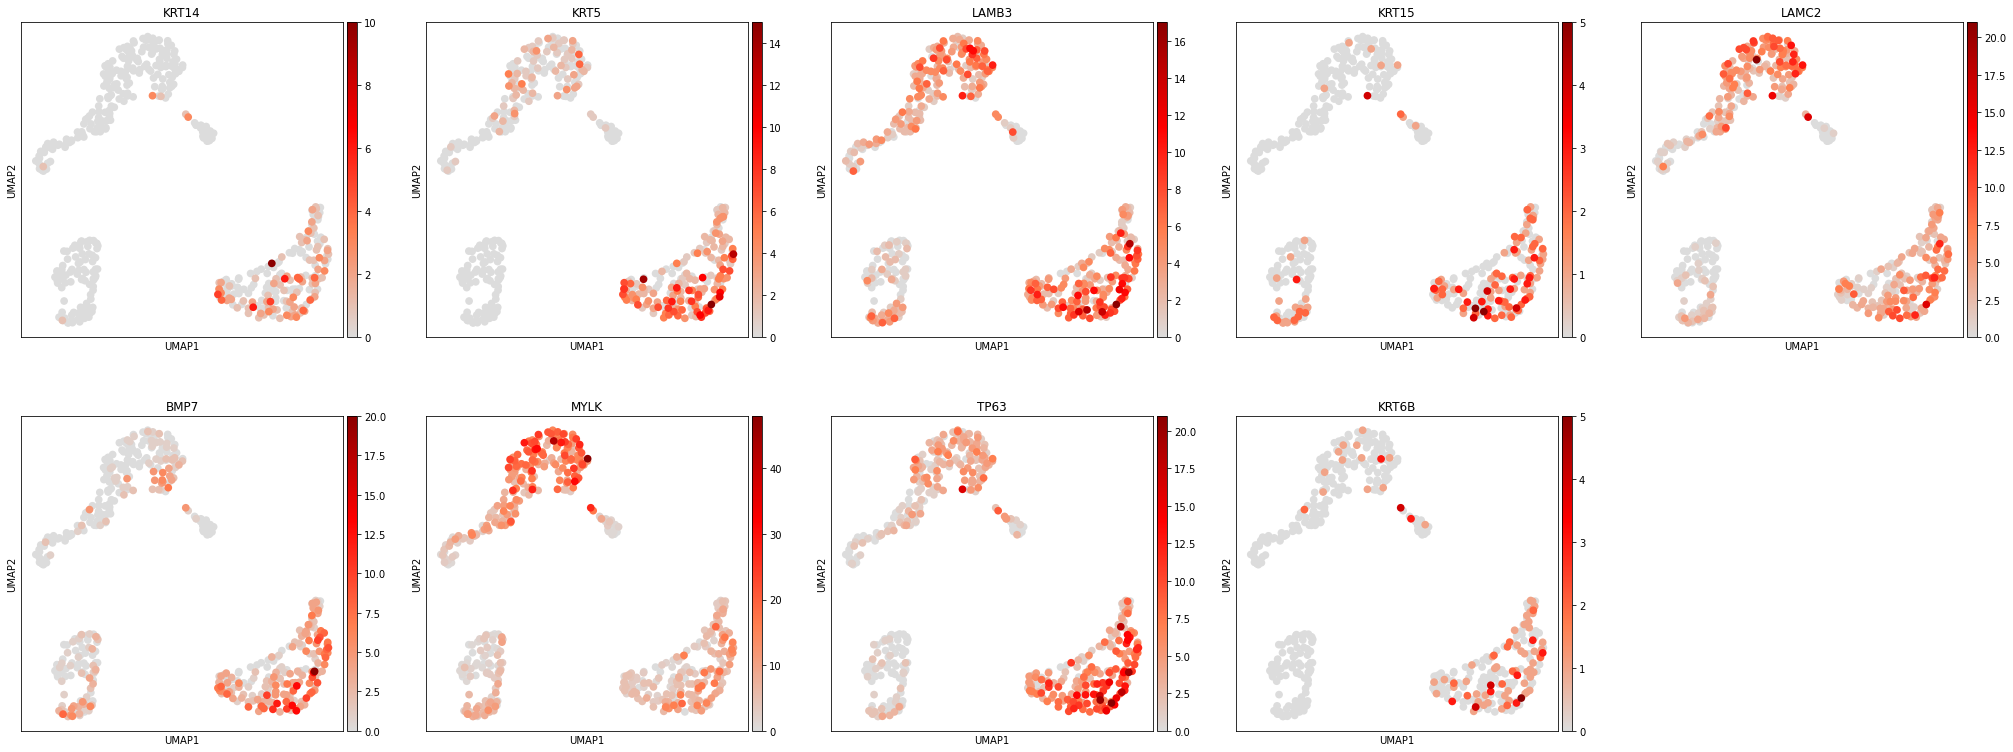

In [37]:
sc.pl.umap(adata_atac, color=markers_basal, ncols=5, color_map=cmap)

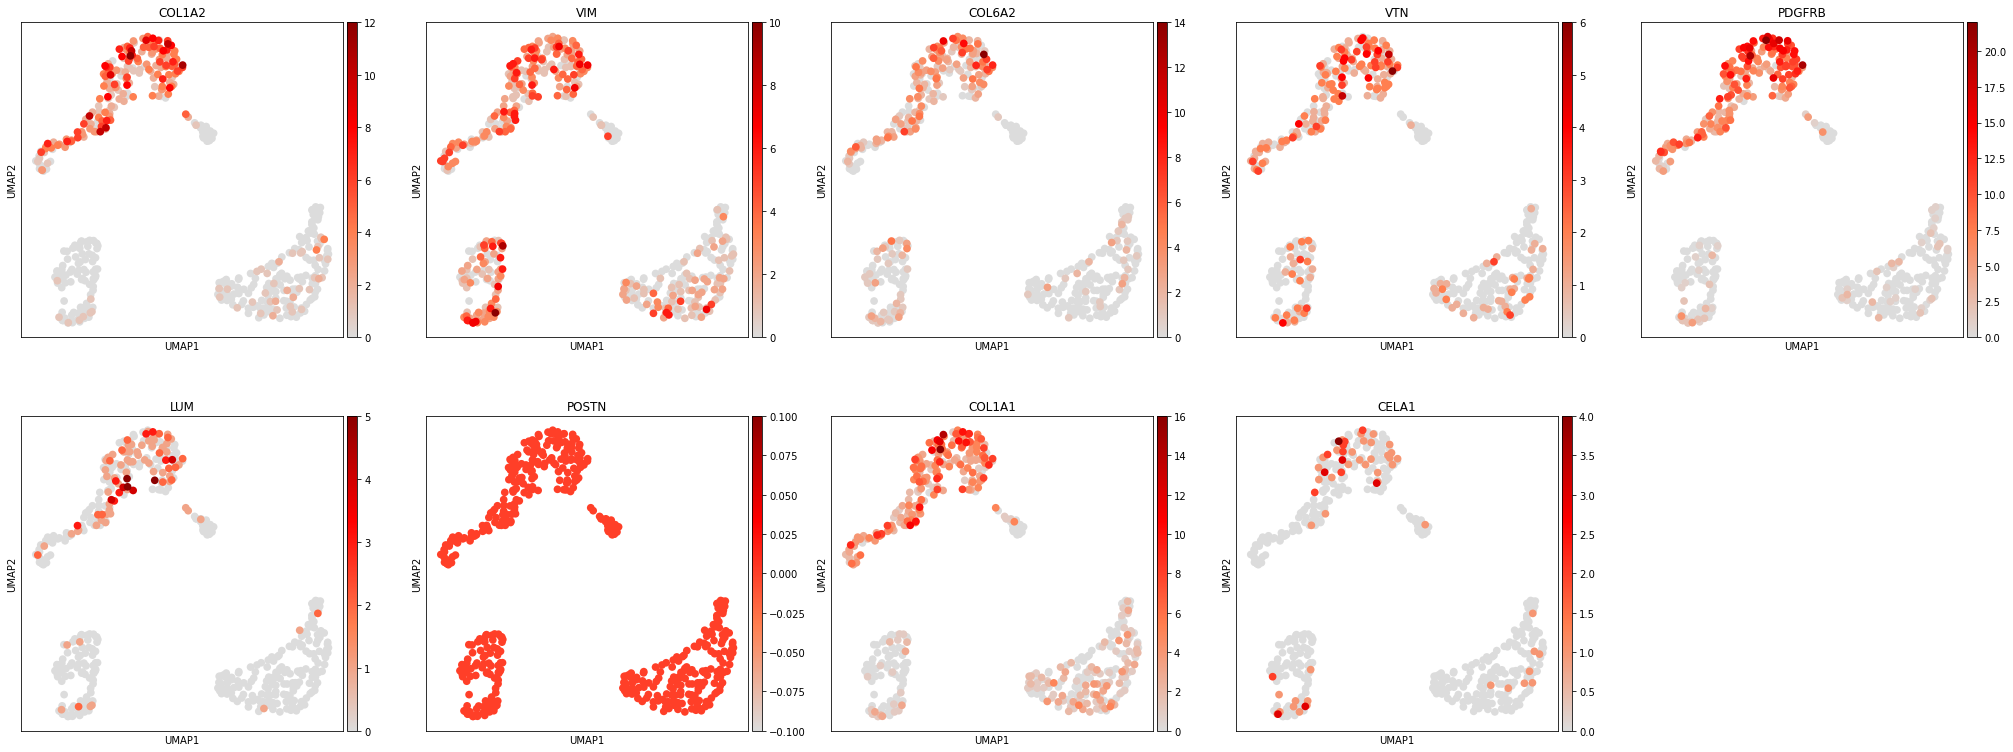

In [38]:
sc.pl.umap(adata_atac, color=markers_fibroblasts, ncols=5, color_map=cmap)

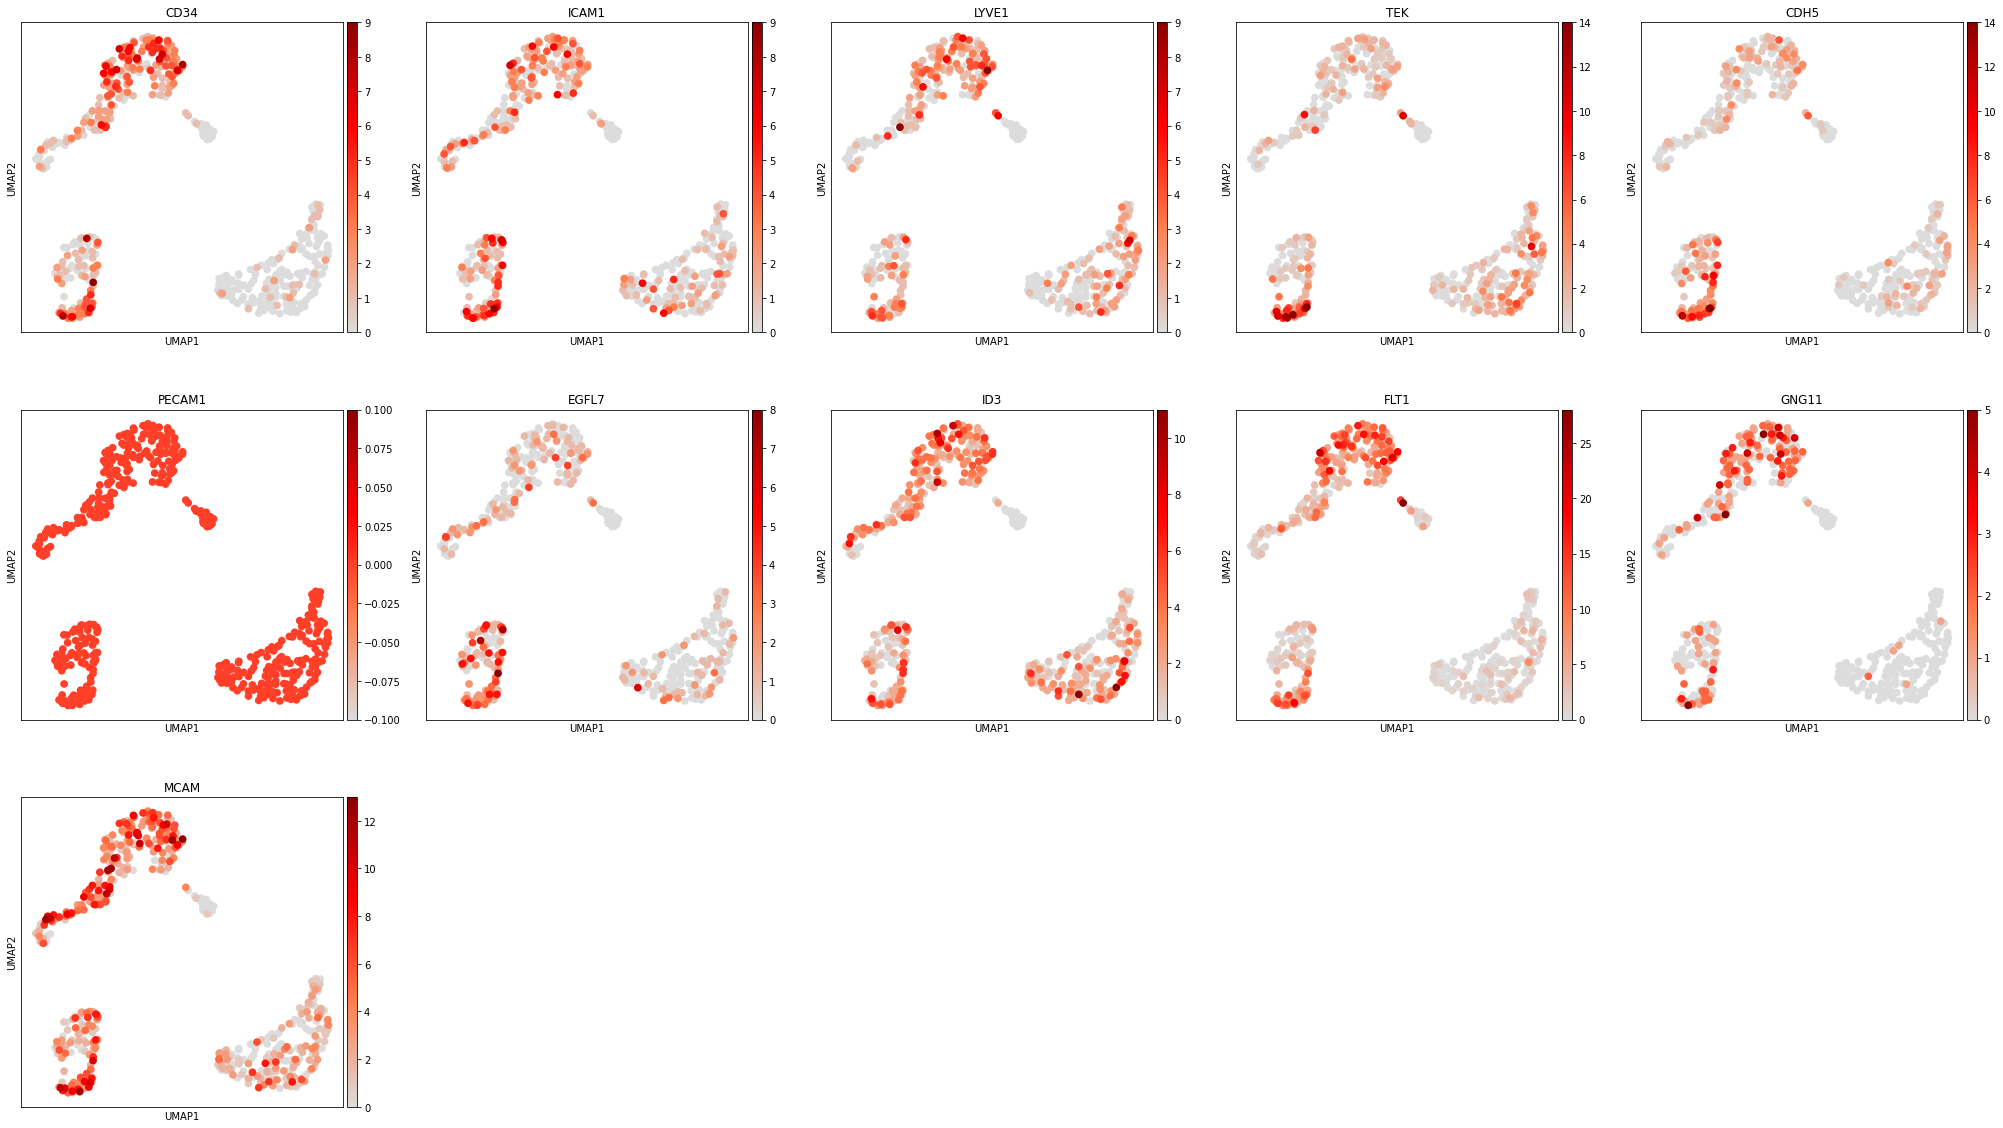

In [39]:
sc.pl.umap(adata_atac, color=markers_endothelial, ncols=5, color_map=cmap)

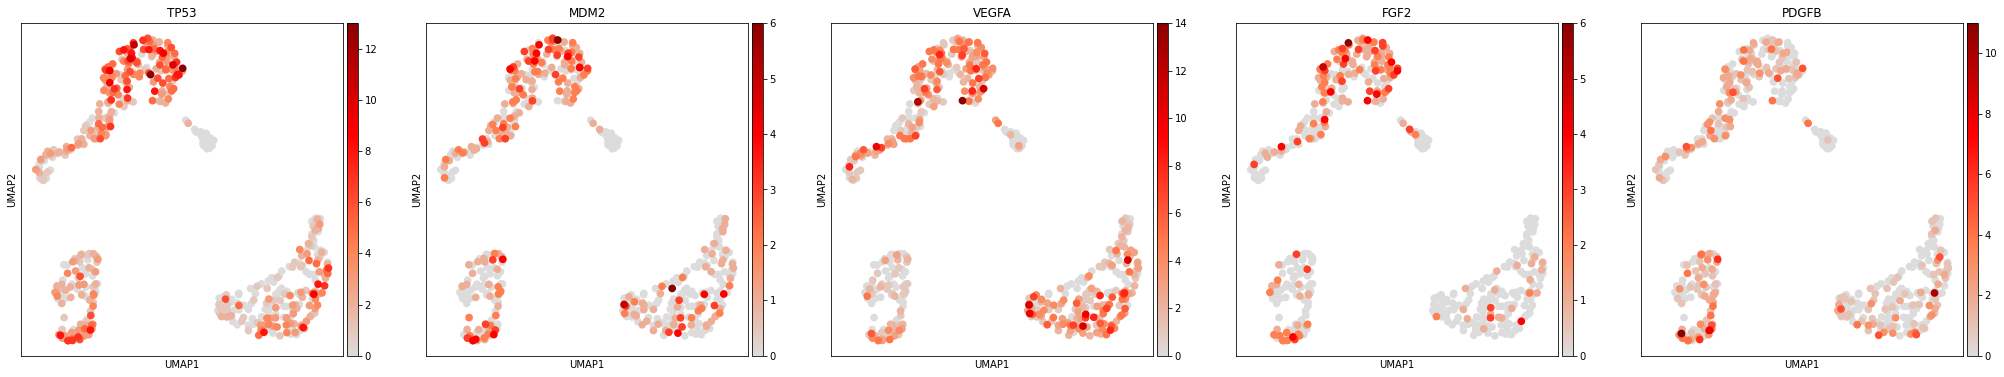

In [40]:
sc.pl.umap(adata_atac, color=markers_others, ncols=5, color_map=cmap)

<br><br><br><hr><br><br><br>

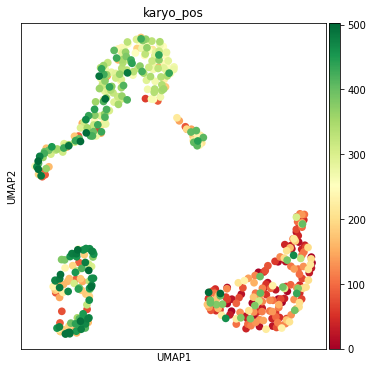

In [41]:
adata_atac.obs["karyo_pos"] = [list_of_barcodes.bc[list_of_barcodes.bc == bc].index[0] for bc in adata_atac.obs.index if bc in list_of_barcodes.bc.values]
sc.pl.umap(adata_atac, color=["karyo_pos"], ncols=3, save="_atac_emb_most_var_{}_filtered_karyo_pos.png".format(n_features_selected), color_map="RdYlGn")

In [42]:
n_bins = 10
end_index = list_of_barcodes.shape[0]

bin_size = np.ceil(end_index / n_bins)

[end_index - bin_size * (n_bins - 1)]

bins = []
for i in range(n_bins):
    reps = end_index - bin_size * (n_bins - 1) if i == n_bins - 1 else bin_size
    for _ in range(int(reps)):
        bins.append(i)
        
list_of_barcodes["bin"] = bins
tmp = {bc: bin for bc, bin in zip(list_of_barcodes.bc, list_of_barcodes.bin)}
adata_atac.obs["bin"] = [str(tmp[bc]) for bc in adata_atac.obs.index]

... storing 'bin' as categorical


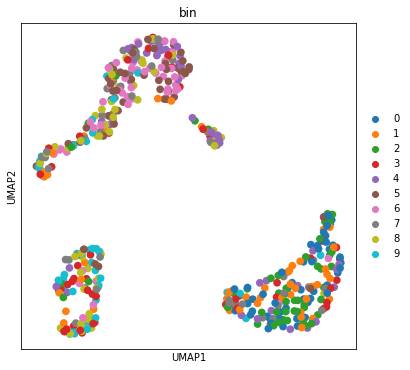

In [43]:
sc.pl.umap(adata_atac, color=["bin"], ncols=3, save="_atac_emb_most_var_{}_filtered_karyo_pos_bins.png".format(n_features_selected), color_map="tab10")

<br><br><br><hr><br><br><br>

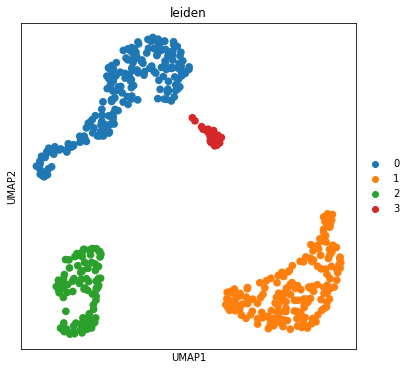

In [44]:
epi.tl.leiden(adata_atac, resolution=0.05)
sc.pl.umap(adata_atac, color=["leiden"], ncols=2, save="_atac_emb_most_var_{}_leiden.png".format(n_features_selected))

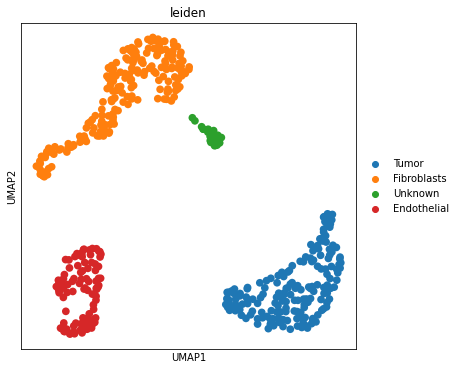

In [45]:
tmp_dict = {
    "0": "Fibroblasts",
    "1": "Tumor",
    "2": "Endothelial",
    "3": "Unknown"
}
adata_atac.obs["leiden"] = [tmp_dict[x] for x in adata_atac.obs.leiden]
adata_atac.obs.leiden = adata_atac.obs.leiden.astype("category")
adata_atac.obs.leiden = adata_atac.obs.leiden.cat.reorder_categories(["Tumor", "Fibroblasts", "Unknown", "Endothelial"])
sc.pl.umap(adata_atac, color=["leiden"], ncols=2, save="_atac_emb_most_var_{}_leiden_mod.png".format(n_features_selected))

In [46]:
# tmp = adata_atac[adata_atac.obs.leiden.isin(["0","1","2","3"])].copy()
# # del tmp.uns["dendrogram_leiden"]
# epi.tl.rank_features(tmp, 'leiden', omic='ATAC', use_raw=False)
# epi.pl.rank_feat_groups_matrixplot(tmp, save="_{}_rm_c4.png".format(n_features_selected))
# epi.pl.rank_feat_groups(tmp, feature_symbols='gene_annotation', n_features=15, ncols=4, fontsize=12, save="_annotation_{}_rm_c4.png".format(n_features_selected))

In [47]:
# groups = np.sort(tmp.obs[tmp.uns["rank_features_groups"]["params"]["groupby"]].unique().to_numpy())
# regions_per_group = [(group, [region.replace("_", "\t") for region in tmp.uns["rank_features_groups"]["names"][group]]) for group in groups]

In [48]:
# for group, regions in regions_per_group:
#     with open("{}{}_regions_group_{}_rm_c4.bed".format(base_dir, name, group), "w") as fh:
#         for region in regions:
#             fh.write("{}\n".format(region))

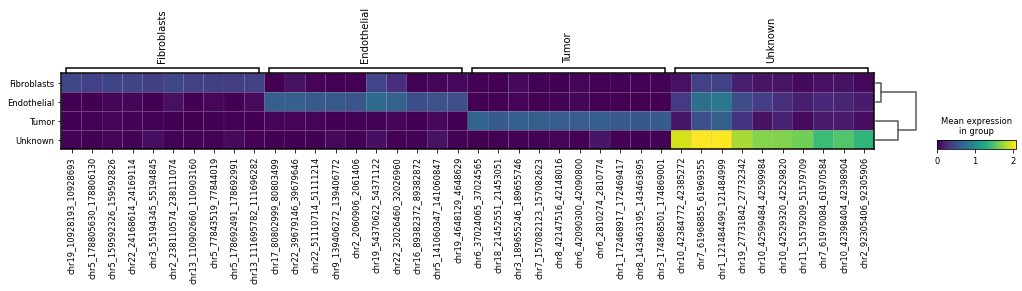

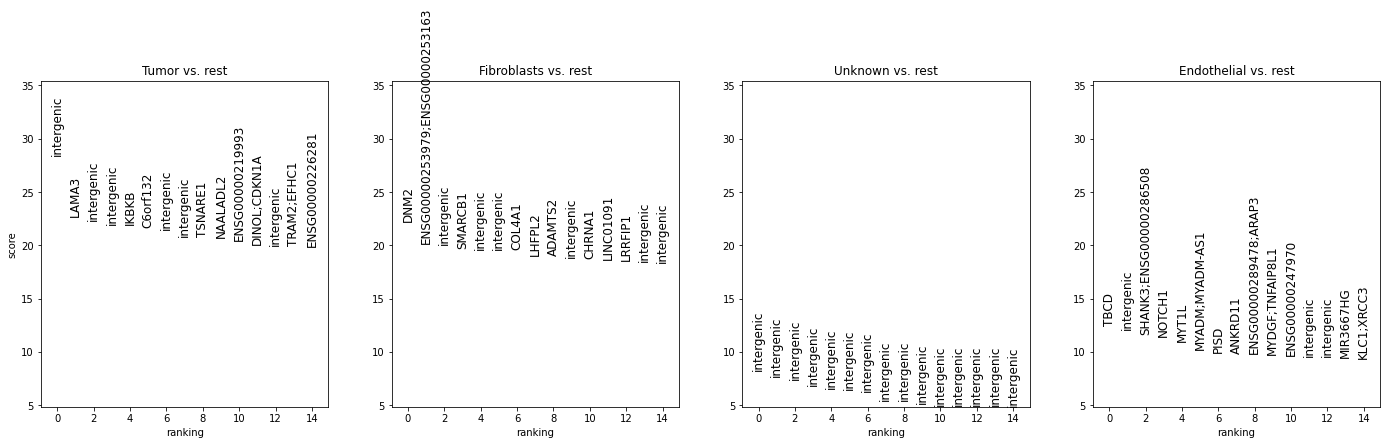

In [49]:
# del adata_atac.uns["dendrogram_leiden"]
epi.tl.rank_features(adata_atac, 'leiden', omic='ATAC', use_raw=False)
epi.pl.rank_feat_groups_matrixplot(adata_atac, save="_{}.png".format(n_features_selected))
epi.pl.rank_feat_groups(adata_atac, feature_symbols='gene_annotation', n_features=15, ncols=4, fontsize=12, save="_annotation_{}.png".format(n_features_selected))

In [50]:
groups = np.sort(adata_atac.obs[adata_atac.uns["rank_features_groups"]["params"]["groupby"]].unique().to_numpy())
regions_per_group = [(group, [region.replace("_", "\t") for region in adata_atac.uns["rank_features_groups"]["names"][group]]) for group in groups]

In [51]:
for group, regions in regions_per_group:
    with open("{}{}_regions_group_{}.bed".format(base_dir, name, group), "w") as fh:
        for region in regions:
            fh.write("{}\n".format(region))

<br><br><br><hr><br><br><br>

In [52]:
# karyo_clusters = pd.read_csv(base_dir + "SU008_Pre_Final_cells_in_clusters.csv")
karyo_clusters = pd.read_csv(base_dir + "SU008_Pre_cells_in_clusters_7.csv")

karyo_clusters

,Cluster1.1 (5),Cluster1.2 (6),Cluster1.3 (7),Cluster2 (2),Cluster3.1 (3),Cluster3.2 (4),Cluster3.3 (1),Cliuster3.3.1,Cluster3.3.2,Cluster3.3.3
0,cell-AGCCCGAAGCGTTGCC-1,cell-AACCAACCAAAGAAGG-1,cell-TTAGCTTTCGGTCTAA-1,cell-TGGCCTTCACTGCTCT-1,cell-GAGATTCAGACTAGGC-1,cell-TCTCAGCTCGCACCGA-1,Cell-GGGTGTCAGCAGAATT-1,cell-CCCTCTCCACACACCG-1,cell-CCCTCTCTCTGACTTT-1,cell-GGGTGTCAGCAGAATT-1
1,cell-AGGCCTGTCGGGATCC-1,cell-ACAATCGTCTCATCCG-1,cell-GGTGCTGGTTGCTTGA-1,cell-TGCCTGTCAGAACTTC-1,cell-TTGACGATCGTGGTAT-1,cell-TATCTGTAGGAAACTT-1,cell-CCCTCTCCACACACCG-1,cell-AGTCAACAGAGATTAC-1,cell-ACAAACCCAACTCAAC-1,cell-AACTTGGGTGAATCGG-1
2,cell-GGGAACAAGGTTCGAG-1,cell-GTAGTACAGACACAAT-1,cell-TCACTCGTCTAGCAAC-1,cell-ATTGTGGTCGTTACAG-1,cell-ACCTGCTGTCAAATCC-1,cell-TTGCGGGGTACCAAGG-1,cell-CCCTCTCTCTGACTTT-1,cell-TAGGTCAAGAGGCCTA-1,cell-ATTACTCTCTTACTCA-1,cell-TCAGTTTTCACTAGGT-1
3,cell-GAGTGAGAGTGATATG-1,cell-TCAGTCCTCCAGTACA-1,cell-ACATGGTGTAGTGATA-1,cell-TGCTCACGTAGCTGTT-1,cell-GGTTGCGGTTGAATAG-1,cell-CCGTACTTCTTCACTA-1,cell-ACAAACCCAACTCAAC-1,cell-TGGGTTACATAGAATG-1,cell-AGGACGAGTAGCAGCA-1,cell-CTTGCTGTCTGAAAGA-1
4,cell-TCGCAGGCATTAAGGA-1,cell-TCAATTCCACGCGATC-1,cell-ATTACTCCAGCAGGTA-1,cell-CATAACGCATATTGGC-1,cell-CCCTGATAGTGTCACT-1,cell-ATGTACGCACATAAAG-1,cell-ATTACTCTCTTACTCA-1,cell-GAAAGTACAGATTTGC-1,cell-TCAGGGCGTTCCGCGA-1,cell-AACTTGGTCCCGGGTA-1
...,...,...,...,...,...,...,...,...,...,...
122,NaN,NaN,NaN,NaN,NaN,NaN,cell-CTAACTTAGCTAACAA-1,NaN,NaN,NaN
123,NaN,NaN,NaN,NaN,NaN,NaN,cell-AACTTGGTCCACCTAC-1,NaN,NaN,NaN
124,NaN,NaN,NaN,NaN,NaN,NaN,cell-CACTGAAGTAGATTAG-1,NaN,NaN,NaN
125,NaN,NaN,NaN,NaN,NaN,NaN,cell-TTACGGATCATGTTCT-1,NaN,NaN,NaN


In [53]:
cluster_1_1 = ["-".join(x[1:]) for x in karyo_clusters["Cluster1.1 (5)"].dropna().str.split("-")]
cluster_1_2 = ["-".join(x[1:]) for x in karyo_clusters["Cluster1.2 (6)"].dropna().str.split("-")]
cluster_1_3 = ["-".join(x[1:]) for x in karyo_clusters["Cluster1.3 (7)"].dropna().str.split("-")]
cluster_2 = ["-".join(x[1:]) for x in karyo_clusters["Cluster2 (2)"].dropna().str.split("-")]
cluster_3_1 = ["-".join(x[1:]) for x in karyo_clusters["Cluster3.1 (3)"].dropna().str.split("-")]
cluster_3_2 = ["-".join(x[1:]) for x in karyo_clusters["Cluster3.2 (4)"].dropna().str.split("-")]
cluster_3_3 = ["-".join(x[1:]) for x in karyo_clusters["Cluster3.3 (1)"].dropna().str.split("-")]
cluster_3_3_1 = ["-".join(x[1:]) for x in karyo_clusters["Cliuster3.3.1"].dropna().str.split("-")]
cluster_3_3_2 = ["-".join(x[1:]) for x in karyo_clusters["Cluster3.3.2"].dropna().str.split("-")]
cluster_3_3_3 = ["-".join(x[1:]) for x in karyo_clusters["Cluster3.3.3"].dropna().str.split("-")]

karyo_cluster_per_bc = {}
for i, bcs in zip(["1.1", "1.2", "1.3", "2", "3.1", "3.2", "3.3.1", "3.3.2", "3.3.3"], [cluster_1_1, cluster_1_2, cluster_1_3, cluster_2, cluster_3_1, cluster_3_2, cluster_3_3_1, cluster_3_3_2, cluster_3_3_3]):
    for bc in bcs:
        karyo_cluster_per_bc[bc] = str(i)

len(karyo_cluster_per_bc)

504

In [54]:
adata_atac.obs["karyo_cluster"] = [karyo_cluster_per_bc[bc] for bc in adata_atac.obs.index]
adata_atac.obs

,KRT14,KRT5,LAMB3,KRT15,LAMC2,BMP7,MYLK,TP63,KRT6B,COL1A2,...,MDM2,VEGFA,FGF2,PDGFB,n_features,log_n_features,karyo_pos,bin,leiden,karyo_cluster
AAACGAAAGATTGACA-1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,4555.0,3.658488,148,2,Endothelial,2
AAACGAAAGCTACGTT-1,1.0,2.0,2.0,0.0,1.0,4.0,5.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,9490.0,3.977266,166,3,Tumor,2
AAACGAACACAAACAA-1,1.0,2.0,9.0,2.0,7.0,10.0,12.0,14.0,3.0,1.0,...,1.0,11.0,0.0,3.0,27297.0,4.436115,109,2,Tumor,1.3
AAACTGCTCATCATGG-1,0.0,5.0,7.0,0.0,1.0,9.0,4.0,3.0,0.0,0.0,...,0.0,0.0,0.0,1.0,17844.0,4.251492,66,1,Tumor,1.1
AAAGATGAGCCATCAT-1,0.0,0.0,5.0,0.0,3.0,0.0,18.0,3.0,0.0,1.0,...,2.0,6.0,0.0,0.0,20257.0,4.306575,330,6,Fibroblasts,3.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGGTCCAGCAAGGTC-1,0.0,0.0,0.0,0.0,3.0,0.0,4.0,1.0,0.0,1.0,...,1.0,3.0,0.0,0.0,12864.0,4.109376,146,2,Fibroblasts,2
TTGTCTAAGAACGTCG-1,2.0,0.0,0.0,1.0,2.0,2.0,3.0,8.0,1.0,0.0,...,0.0,4.0,0.0,1.0,15005.0,4.176236,47,0,Tumor,1.1
TTGTTCAGTAGCATGG-1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,658.0,2.818226,410,8,Unknown,3.3.1
TTGTTGTGTTGCTTGA-1,0.0,0.0,3.0,0.0,7.0,0.0,1.0,2.0,0.0,2.0,...,1.0,2.0,1.0,5.0,21244.0,4.327236,298,5,Fibroblasts,3.2


In [55]:
# adata_atac.obs["karyo_cluster_adj"] = [c[0] for c in adata_atac.obs.karyo_cluster]
adata_atac.obs["karyo_cluster_adj"] = [c[0:3] for c in adata_atac.obs.karyo_cluster]
adata_atac.obs["karyo_cluster_adj"] = adata_atac.obs.karyo_cluster_adj.astype("category")

In [56]:
adata_atac.obs.karyo_cluster.value_counts()

2        96
3.2      82
1.1      67
3.3.3    60
3.1      59
1.3      48
3.3.1    34
3.3.2    33
1.2      25
Name: karyo_cluster, dtype: int64

In [57]:
adata_atac.obs.leiden.value_counts()

Fibroblasts    202
Tumor          182
Endothelial     97
Unknown         23
Name: leiden, dtype: int64

In [58]:
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics.cluster import adjusted_mutual_info_score
from sklearn.metrics.cluster import homogeneity_score

In [59]:
ari = adjusted_rand_score(adata_atac.obs.karyo_cluster, adata_atac.obs.leiden)
ami = adjusted_mutual_info_score(adata_atac.obs.karyo_cluster, adata_atac.obs.leiden)
hom = homogeneity_score(adata_atac.obs.karyo_cluster, adata_atac.obs.leiden)

print(ari, ami, hom)

0.19640672996549843 0.29952947672258673 0.24242397149713607


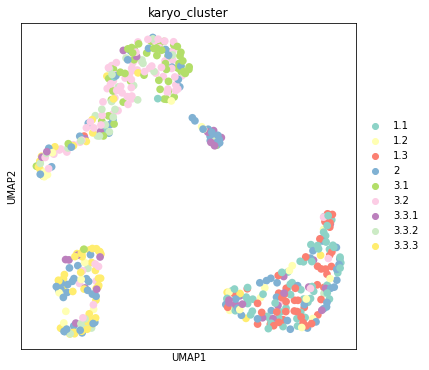

In [79]:
sc.pl.umap(adata_atac, color=["karyo_cluster"], ncols=3, save="_atac_emb_most_var_{}_karyo_cluster.png".format(n_features_selected), palette="Set3")

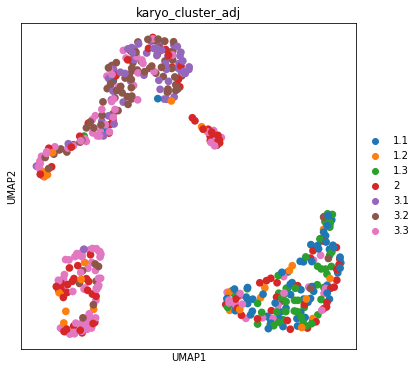

In [61]:
sc.pl.umap(adata_atac, color=["karyo_cluster_adj"], ncols=3, save="_atac_emb_most_var_{}_karyo_cluster_adj.png".format(n_features_selected), color_map="tab10")

In [62]:
joint_emb_clusters = pd.read_csv(base_dir + "joint_emb_clusters.csv", index_col=0)
joint_emb_clusters

,leiden
AAACGAAAGATTGACA-1-s008_pre,3
AAACGAAAGCTACGTT-1-s008_pre,4
AAACGAACACAAACAA-1-s008_pre,4
AAACTGCTCATCATGG-1-s008_pre,4
AAAGATGAGCCATCAT-1-s008_pre,2
...,...
TTTGGTTTCGGAAAGC-1-s006_pre,5
TTTGTGTAGGTAAGCC-1-s006_pre,0
TTTGTGTCACTGATAC-1-s006_pre,5
TTTGTGTCATTAAGGA-1-s006_pre,1


In [63]:
joint_emb_clusters_dict = {k.replace("-s008_pre", ""): str(v) for k, v in zip(joint_emb_clusters.index, joint_emb_clusters.leiden) if "s008" in k}
adata_atac.obs["joint_emb_clusters"] = [joint_emb_clusters_dict[k] for k in adata_atac.obs.index]

... storing 'joint_emb_clusters' as categorical


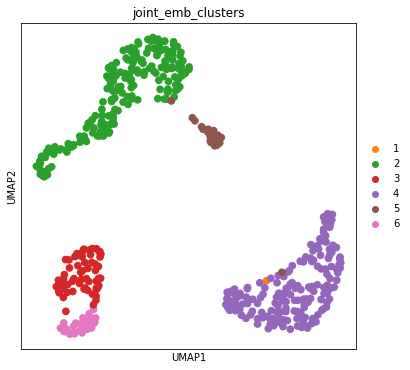

In [64]:
tab10 = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown", "tab:pink", "tab:gray", "tab:olive", "tab:cyan"]
cs = [tab10[int(i)] for i in np.sort([int(x) for x in adata_atac.obs.joint_emb_clusters.unique()])]
sc.pl.umap(adata_atac, color=["joint_emb_clusters"], ncols=3, save="_atac_emb_most_var_{}_joint_emb_clusters.png".format(n_features_selected), palette=cs)

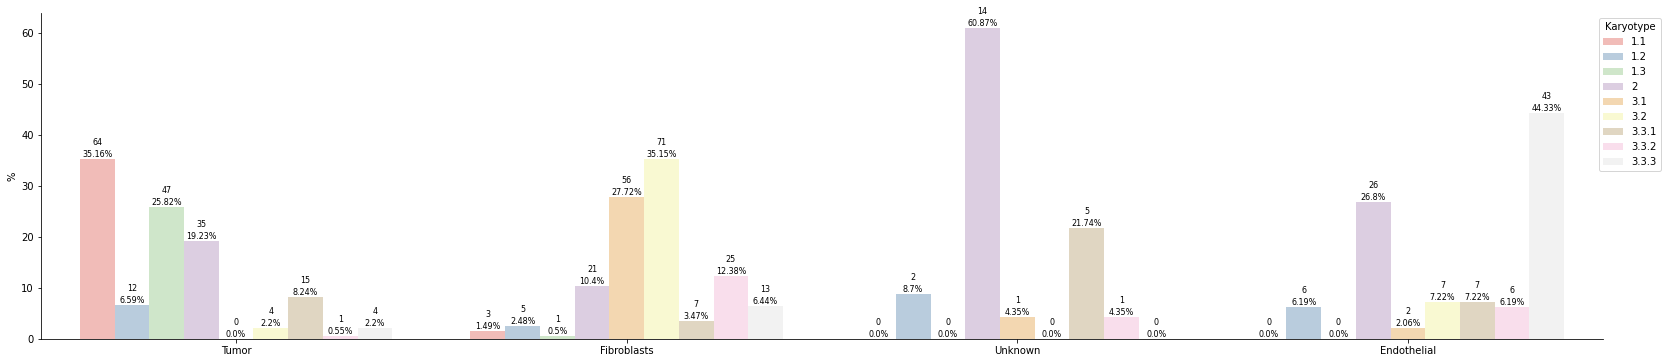

In [65]:
res = {"leiden": [], "karyotype": [], "pct": [], "n": []}

for c_1 in adata_atac.obs.leiden.unique():
    
    n_total = adata_atac.obs[adata_atac.obs.leiden == c_1].shape[0]

    tmp = adata_atac.obs[adata_atac.obs.leiden == c_1].karyo_cluster.value_counts()
    tmp = tmp.to_dict()

    for c_2, n in tmp.items():
        res["leiden"].append(c_1)
        res["karyotype"].append(c_2)
        res["n"].append(n)
        res["pct"].append(np.round((n / n_total) * 100, decimals=2))
        
res = pd.DataFrame(res)
res["leiden"] = res.leiden.astype("category")
res["leiden"] = res.leiden.cat.reorder_categories(["Tumor", "Fibroblasts", "Unknown", "Endothelial"])
res = res.sort_values(by=["leiden", "karyotype"], ignore_index=True)

fig, ax = plt.subplots(figsize=(28,6), nrows=1, ncols=1, squeeze=True)

sns.barplot(data=res, x="leiden", y="pct", hue="karyotype", palette="Pastel1", ax=ax)

for i, p in enumerate(ax.patches):
    ax.annotate(text="{}%".format(res.sort_values(by=["karyotype", "leiden"], ignore_index=True).pct[i]),
                xy=(p.get_x() + p.get_width() / 2, p.get_height()),
                xytext=(0, 5),
                textcoords="offset points",
                fontsize=8,
                ha="center",
                va="center")
    ax.annotate(text=res.sort_values(by=["karyotype", "leiden"], ignore_index=True).n[i],
                xy=(p.get_x() + p.get_width() / 2, p.get_height()),
                xytext=(0, 5 + 12),
                textcoords="offset points",
                fontsize=8,
                ha="center",
                va="center")
    
ax.set_xlabel("")
ax.set_ylabel("%")
ax.legend(bbox_to_anchor=(1.04, 1), title="Karyotype")

sns.despine()
plt.savefig(fig_dir + "karyotype_per_leiden_pastel1.png", dpi=300)

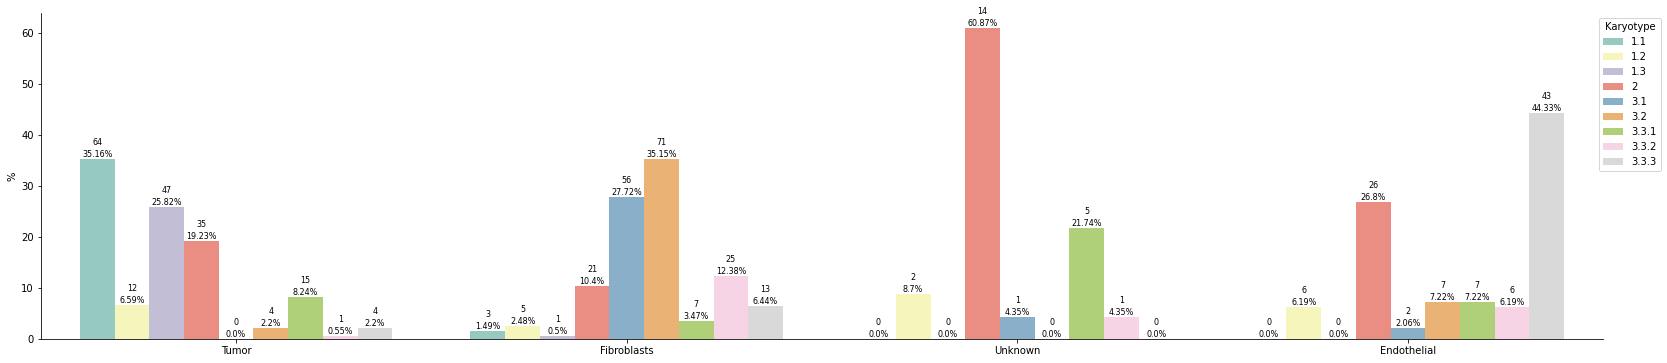

In [66]:
res = {"leiden": [], "karyotype": [], "pct": [], "n": []}

for c_1 in adata_atac.obs.leiden.unique():
    
    n_total = adata_atac.obs[adata_atac.obs.leiden == c_1].shape[0]

    tmp = adata_atac.obs[adata_atac.obs.leiden == c_1].karyo_cluster.value_counts()
    tmp = tmp.to_dict()

    for c_2, n in tmp.items():
        res["leiden"].append(c_1)
        res["karyotype"].append(c_2)
        res["n"].append(n)
        res["pct"].append(np.round((n / n_total) * 100, decimals=2))
        
res = pd.DataFrame(res)
res["leiden"] = res.leiden.astype("category")
res["leiden"] = res.leiden.cat.reorder_categories(["Tumor", "Fibroblasts", "Unknown", "Endothelial"])
res = res.sort_values(by=["leiden", "karyotype"], ignore_index=True)

fig, ax = plt.subplots(figsize=(28,6), nrows=1, ncols=1, squeeze=True)

sns.barplot(data=res, x="leiden", y="pct", hue="karyotype", palette="Set3", ax=ax)

for i, p in enumerate(ax.patches):
    ax.annotate(text="{}%".format(res.sort_values(by=["karyotype", "leiden"], ignore_index=True).pct[i]),
                xy=(p.get_x() + p.get_width() / 2, p.get_height()),
                xytext=(0, 5),
                textcoords="offset points",
                fontsize=8,
                ha="center",
                va="center")
    ax.annotate(text=res.sort_values(by=["karyotype", "leiden"], ignore_index=True).n[i],
                xy=(p.get_x() + p.get_width() / 2, p.get_height()),
                xytext=(0, 5 + 12),
                textcoords="offset points",
                fontsize=8,
                ha="center",
                va="center")
    
ax.set_xlabel("")
ax.set_ylabel("%")
ax.legend(bbox_to_anchor=(1.04, 1), title="Karyotype")

sns.despine()
plt.savefig(fig_dir + "karyotype_per_leiden_set3.png", dpi=300)

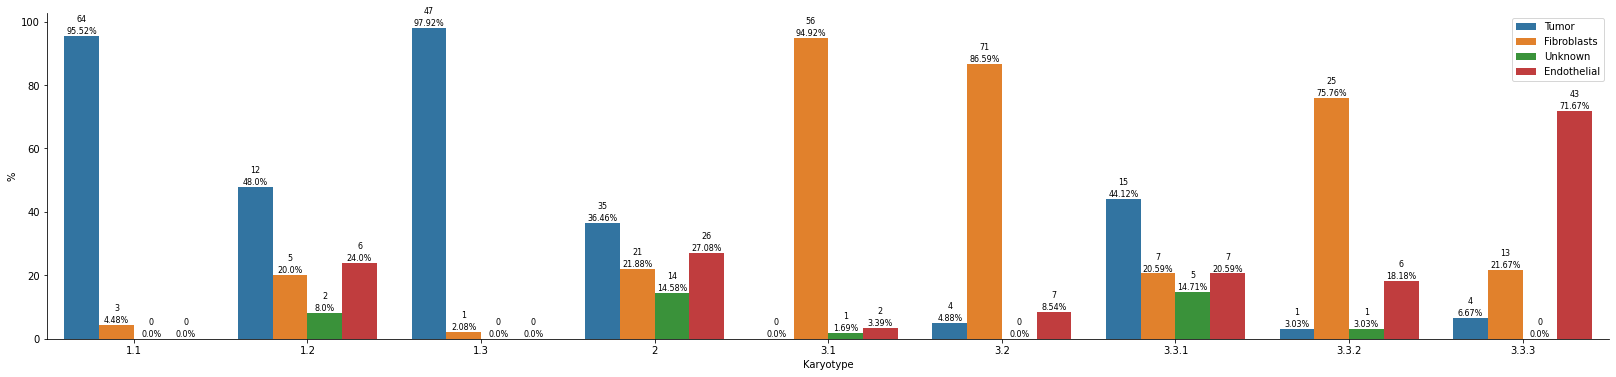

In [67]:
res = {"leiden": [], "karyotype": [], "pct": [], "n": []}

for c_1 in adata_atac.obs.karyo_cluster.unique():
    
    n_total = adata_atac.obs[adata_atac.obs.karyo_cluster == c_1].shape[0]

    tmp = adata_atac.obs[adata_atac.obs.karyo_cluster == c_1].leiden.value_counts()
    tmp = tmp.to_dict()

    for c_2, n in tmp.items():
        res["karyotype"].append(c_1)
        res["leiden"].append(c_2)
        res["n"].append(n)
        res["pct"].append(np.round((n / n_total) * 100, decimals=2))
        
res = pd.DataFrame(res)
res["leiden"] = res.leiden.astype("category")
res["leiden"] = res.leiden.cat.reorder_categories(["Tumor", "Fibroblasts", "Unknown", "Endothelial"])
res = res.sort_values(by=["karyotype", "leiden"], ignore_index=True)

fig, ax = plt.subplots(figsize=(28,6), nrows=1, ncols=1, squeeze=True)

sns.barplot(data=res, x="karyotype", y="pct", hue="leiden", ax=ax)

for i, p in enumerate(ax.patches):
    ax.annotate(text="{}%".format(res.sort_values(by=["leiden", "karyotype"], ignore_index=True).pct[i]),
                xy=(p.get_x() + p.get_width() / 2, p.get_height()),
                xytext=(0, 5),
                textcoords="offset points",
                fontsize=8,
                ha="center",
                va="center")
    ax.annotate(text=res.sort_values(by=["leiden", "karyotype"], ignore_index=True).n[i],
                xy=(p.get_x() + p.get_width() / 2, p.get_height()),
                xytext=(0, 5 + 12),
                textcoords="offset points",
                fontsize=8,
                ha="center",
                va="center")
    
ax.set_xlabel("Karyotype")
ax.set_ylabel("%")
# ax.legend().set_visible(False)
ax.legend(title=None)

sns.despine()
plt.savefig(fig_dir + "leiden_per_karyotype.png", dpi=300)

<br><br><br><hr><br><br><br>

In [68]:
with open("{}{}_clusters.pickle".format(base_dir, name), "wb") as fh:
    pickle.dump({k: v for k, v in zip(adata_atac.obs_names, adata_atac.obs.leiden)}, fh)

In [69]:
with open("{}{}_clusters.pickle".format(base_dir, name), "rb") as fh:
    cluster_per_barcode = pickle.load(fh)
    
# cluster_per_barcode

In [70]:
tmp = pd.DataFrame({"barcode": adata_atac.obs_names.values, "cluster_id": adata_atac.obs.leiden.values})
tmp.to_csv("{}{}_clusters.csv".format(base_dir, name), index=False)

In [71]:
with open("{}{}_bins.pickle".format(base_dir, name), "wb") as fh:
    pickle.dump({k: v for k, v in zip(adata_atac.obs_names, adata_atac.obs.bin)}, fh)

In [72]:
with open("{}{}_karyotypes.pickle".format(base_dir, name), "wb") as fh:
    pickle.dump({k: v for k, v in zip(adata_atac.obs_names, adata_atac.obs.karyo_cluster)}, fh)

In [73]:
# pd.Series(adata_atac[np.logical_and(adata_atac.obs.bin == "6", adata_atac.obs.leiden == "2")].obs.index.to_list()).to_csv("{}{}_barcodes_to_check.csv".format(base_dir, name), index=False, header=False)

In [74]:
# pd.Series(adata_atac[np.logical_and(adata_atac.obs.bin == "6", adata_atac.obs.leiden == "0")].obs.index.to_list()).to_csv("{}{}_barcodes_to_check.csv".format(base_dir, name), index=False, header=False)

<br><br><br><hr><br><br><br>

In [75]:
import matplotlib.patches
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_great(data, x, y, c, s, x_label=None, colorbar_label=None, legend_label=None, save=None):

    fig, ax = plt.subplots(figsize=(6, 6), nrows=1, ncols=1, squeeze=True)

    s_var_scaled = (data[s] / data[s].max()) * 300

    pcol = ax.scatter(
        x=data[x],
        y=data[y],
        c=data[c],
        s=s_var_scaled,
        cmap="viridis_r",
        linewidth=1,
        edgecolor="grey"
    )

    ax.set_xlabel(x if x_label is None else x_label, weight="bold")

    plt.yticks(weight="bold")
    
    ax.invert_yaxis()
    ax.yaxis.grid(True, color="lightgrey")
    ax.set_axisbelow(True)

    divider = make_axes_locatable(ax)
    ax_cbar = divider.append_axes(position="right", size=0, pad=0)
    ax_cbar.axis("off")

    tmp = ax_cbar.get_position()
    tmp.x1 += 0.2
    ax_cbar.set_position(tmp)
    
    cbar_ticks = np.arange(np.ceil(data[c].min()), np.ceil(data[c].max()))

    cbar = plt.colorbar(
        pcol, 
        ax=ax_cbar, 
        shrink=0.6, 
        aspect=20, 
        pad=0, 
        anchor=(0, 0.05),
        ticks=cbar_ticks
    )
    
    cbar.ax.set_yticklabels(["$10^{{{:n}}}$".format(x) for x in cbar_ticks])
    cbar.set_label(label=c if colorbar_label is None else colorbar_label, weight="bold")

    legend_size_vals_min = data[s].min()
    legend_size_vals_max = data[s].max()
    legend_size_vals = np.linspace(start=legend_size_vals_min, stop=legend_size_vals_max, num=4)
    legend_size_vals = np.round(legend_size_vals)
    legend_size_vals_scaled = (legend_size_vals / legend_size_vals_max) * 300

    ax.legend(
        [plt.scatter([], [], s=i, color="black") for i in legend_size_vals_scaled],
        ["{:n}".format(i) for i in legend_size_vals],
        title=s if legend_label is None else legend_label,
        title_fontproperties={"weight": "bold"},
        loc="upper left",
        bbox_to_anchor=(1.05 ,1),
        frameon=True,
        labelspacing=1,
        borderpad=0.8
    )
    
    if save is None:
        plt.show()
    else:
        plt.savefig("{}{}.png".format(fig_dir, save), dpi=600, bbox_inches="tight")

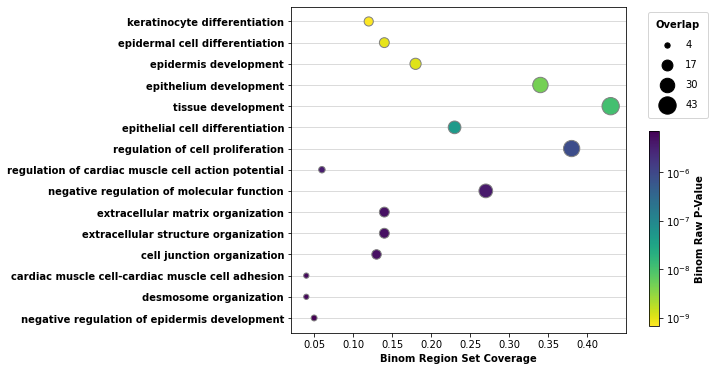

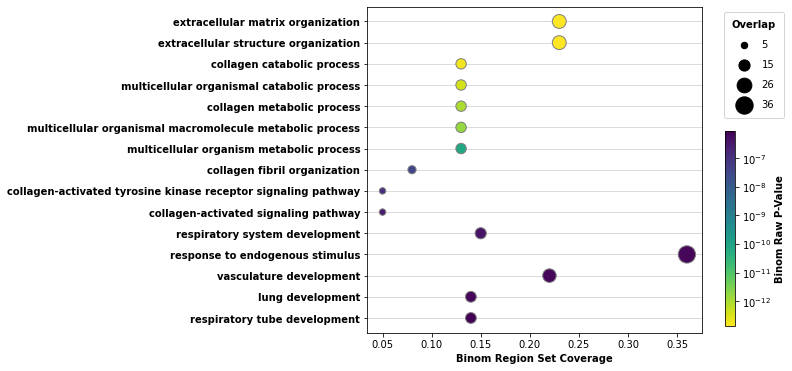

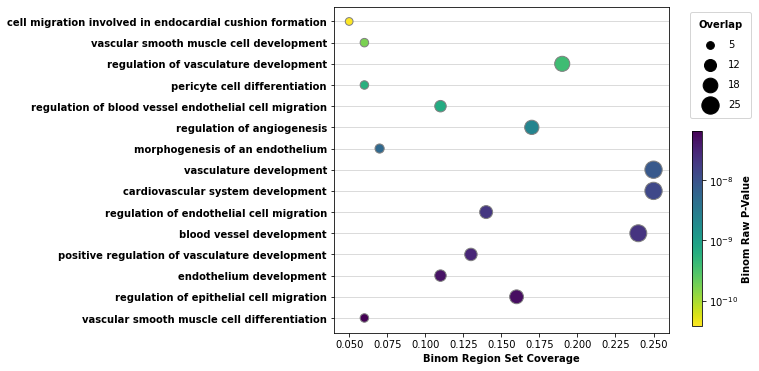

In [76]:
go_files = ["su008_go_tumor.tsv", "su008_go_fib.tsv", "su008_go_endo.tsv"]
for go_file in go_files:
    go_res = pd.read_csv(base_dir + go_file, sep="\t", skiprows=1, index_col=False)
    go_res.columns = [x.strip() for x in go_res.columns]
    go_res = go_res.rename(columns={"# Term Name": "Term Name"})
    go_res = go_res[:15].copy()
    go_res["Binom Raw P-Value"] = np.log10(go_res["Binom Raw P-Value"])
    
    save = go_file.split(".")[0]
    plot_great(data=go_res, x="Binom Region Set Coverage", y="Term Name", c="Binom Raw P-Value", s="Binom Observed Region Hits", legend_label="Overlap", save=save)